Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

## Extract images from videos

This tutorial shows how to extract training images from provided videos.

## Setup environment

In [ ]:
!python -c "import cv2" || pip -q install opencv-python
!python -c "import monai" || pip install -q "monai-weekly[tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib

## Setup imports

In [ ]:
import cv2
import os
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np
from glob import glob
import multiprocessing
from monai.config import print_config
from tqdm import tqdm
%matplotlib inline
rcParams['figure.figsize'] = 10, 10

print_config()

## Setup data directory

In order to reproduce our method, please check the [competition website](https://surgtoolloc.grand-challenge.org/data/) and prepare the dataset.

In [3]:
# replace the dir into your local dir

video_dir = '/raid/surg/_release/training_data/video_clips/'
img_dir = '/raid/surg/image640_blur/'

os.makedirs(img_dir, exist_ok=True)

## Check video and set preprocessing parameters

In [ ]:
cpu_ct = 32

resize = True
fps = 1
size = (512, 640)

In [3]:
video_lst = [os.path.basename(x)[:-4] for x in sorted(glob(video_dir + '*.mp4'))]
len(video_lst)

24695

In [4]:
video_lst[:5]

['clip_000000', 'clip_000001', 'clip_000002', 'clip_000003', 'clip_000004']

Original videos have fps=60 and we extract images at fps=1.

We also:

1. blur the bottom banner which contain label information.
2. remove black empty area on both the left and right sides.

## Preprocessing function

In [4]:
def process_one_video(
    video_name: str,
    orig_fps: int = 60,
    output_fps: int = fps,
    out_dir: str = img_dir,
    save: bool = True,
    show: bool = False,
    blur: bool = True,
    blurness: int = 51,
    side_margin: int = 192,
    bottom_margin: int = 46,
):
    vid_capture = cv2.VideoCapture(video_dir + video_name + '.mp4')

    i = 0
    while (vid_capture.isOpened()):
        # vid_capture.read() methods returns a tuple, first element is a bool
        # and the second is frame
        ret, frame = vid_capture.read()
        if ret is True:
            prev_frame = frame
            if i % (orig_fps // output_fps) == 0:
                if show and i == 0:
                    plt.imshow(frame[:, :, ::-1])
                    plt.title(f"{video_name}, first frame")
                    plt.show()
                if blur:
                    img = frame[:, side_margin:-side_margin, :]
                    blurred_img = cv2.GaussianBlur(img, (blurness, blurness), 0)
                    mask = np.zeros_like(img)
                    mask[:-bottom_margin, :, :] = 1
                    img = np.where(mask, img, blurred_img)
                else:
                    img = frame[:-bottom_margin, side_margin:-side_margin, :]
                if resize:
                    img = cv2.resize(img, (size[1], size[0]))
                if save:
                    cv2.imwrite(os.path.join(out_dir, f'{video_name}_{i//(orig_fps//output_fps)}.jpg'), img)
            i += 1
        else:
            if show:
                plt.imshow(prev_frame[:, :, ::-1])
                plt.title(f"{video_name}, last frame")
                plt.show()
            break

    # Release the video capture object
    vid_capture.release()

## Preprocessing

sanity check one video. Display the resulting first frame and last frame. Do not save.

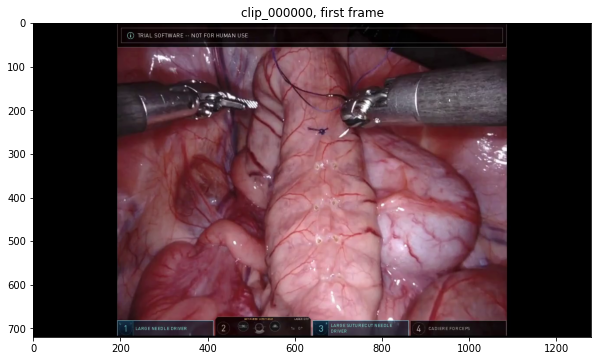

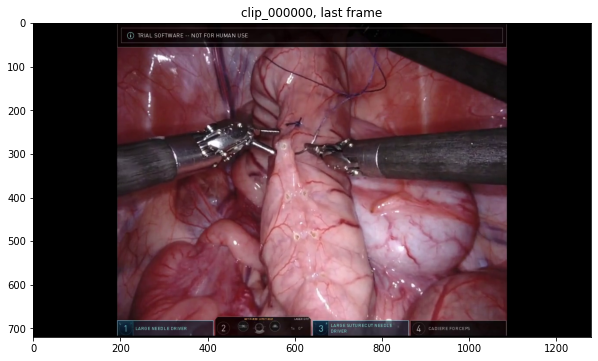

In [6]:
process_one_video('clip_000000', save=False, show=True)

Save all the videos using multiprocessing

In [7]:
with multiprocessing.Pool(cpu_ct) as pool:
    imap = pool.imap(process_one_video, video_lst)
    _ = list(tqdm(imap, total=len(video_lst)))

100%|██████████| 24695/24695 [7:14:16<00:00,  1.06s/it]     
